### REDES NEURONALES

Vamos a intentar a prededecir el precio de un coche. Usaremos los datos que hemos recopilado en *coches.net*.

## 1. Importación de librerías necesarias

In [ ]:
import io
import csv
import json
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.cluster import KMeans
from keras.callbacks import EarlyStopping
from keras. initializers import TruncatedNormal 
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer

## 2. Importación de los datos del dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def open_json_data(path, removeFirstItemsCount = 0, property_to_spread = ''):
    
    with open(path, 'r') as file:
        data = json.load(file)

    for i in range(0, removeFirstItemsCount):
        data.pop(0)

    if property_to_spread != '':
        for i, item in enumerate(data):
            resto_de_datos = item.pop(property_to_spread)
            data[i] = {**item, **resto_de_datos}

    return data

In [ ]:
path = '/content/drive/MyDrive/Programación de Inteligencia Artificial/7. Redes Neuronales/Ejercicios/ProyectoCochesnet/datasets/'
d_files = [f"{path}d{i}.json" for i in range(1, 10)]
d1, d2, d3, d4, d5, d6, d7, d8, d9 = d_files
d10 = path + 'd10.csv'
d11 = path + 'd11.csv'

In [ ]:
d1 = open_json_data(d1, 2, 'resto_de_datos')
d2 = open_json_data(d2, 0, 'resto_de_datos')
d3 = open_json_data(d3, 0, 'resto_de_datos')
d4 = open_json_data(d4, 0, 'resto_de_datos')
d5 = open_json_data(d5, 0, 'resto_de_datos')
d6 = open_json_data(d6, 0, '')
d7 = open_json_data(d7, 0, '')
d8 = open_json_data(d8, 0, 'resto_de_datos')
d9 = open_json_data(d9, 0, 'resto_de_datos')
d10 = pd.read_csv(d10)
d11 = pd.read_csv(d11)

In [ ]:
d10.rename(columns={'body_types': 'bodyType'}, inplace=True)

cols = ['fuelType', 'id', 'km', 'make', 'model', 'price', 'province', 'title', 'transmissionType', 'year', 'seller_type', 'bodyType', 'cubicCapacity', 'doors','hp']
dfs = [pd.DataFrame(d)[cols] for d in [d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11]]

### Concatenación de los dataframes

In [ ]:
df = pd.concat(dfs, ignore_index=True)
df = df.set_index('id')
df = df.rename(columns={'seller_type': 'sellerType'})

In [ ]:
 df.shape[0]

13289

### Eliminación de datos duplicados

In [ ]:
df.drop_duplicates(subset=None, inplace=True)

In [ ]:
 df.shape[0]

11922

### Información acerca de los datos que se acaban de leer

In [ ]:
df.head().T

id,53636299,54598350,54496446,53351930,54617003
fuelType,Híbrido,Diésel,Híbrido,Gasolina,Híbrido
km,13338.0,143000.0,10262.0,130000.0,26728.0
make,LAND-ROVER,LAND-ROVER,LAND-ROVER,LAND-ROVER,LAND-ROVER
model,Range Rover Sport,Range Rover Evoque,Defender,Range Rover Evoque,Discovery Sport
price,88900.0,21000.0,79900.0,23550.0,38400.0
province,Girona,Barcelona,Madrid,Málaga,Barcelona
title,LAND-ROVER Range Rover Sport 3.0D I6 220kW MHE...,LAND-ROVER Range Rover Evoque 2.2L TD4 150CV 4...,LAND-ROVER Defender 3.0 D200 SE 90 Auto 4WD MH...,LAND-ROVER Range Rover Evoque 2.0L Si4 4x4 Dyn...,LAND-ROVER Discovery Sport 2.0D I4L.Flw 150 PS...
transmissionType,COMMON.TRANSMISSION_AUTOMATIC,COMMON.TRANSMISSION_AUTOMATIC,COMMON.TRANSMISSION_AUTOMATIC,COMMON.TRANSMISSION_AUTOMATIC,COMMON.TRANSMISSION_AUTOMATIC
year,2022.0,2013.0,2022.0,2013.0,2019.0
sellerType,profesional,particular,profesional,particular,profesional


In [ ]:
df.dtypes

fuelType             object
km                  float64
make                 object
model                object
price               float64
province             object
title                object
transmissionType     object
year                float64
sellerType           object
bodyType             object
cubicCapacity       float64
doors               float64
hp                  float64
dtype: object

## 3. Preproceso de datos

###  Tratamiento de datos nulos

In [ ]:
df.isnull().sum()

fuelType              1
km                    1
make                  1
model                 1
price                 1
province              1
title                 1
transmissionType      4
year                  1
sellerType            1
bodyType            219
cubicCapacity       359
doors                11
hp                  225
dtype: int64

Definimos listas en las que se guardan los nombre de los campos numéricos y los de los campos categóricos. 

In [ ]:
campos_numericos =  df.select_dtypes(include=['int64', 'float64']).columns.tolist()
campos_categoricos = df.select_dtypes(include=['object']).columns.tolist()
campos  = campos_numericos + campos_categoricos
target = 'price'

print(f'Propiedades numéricas: {campos_numericos} ({len(campos_numericos)})')
print(f'Propiedades categóricas: {campos_categoricos} ({len(campos_categoricos)})')
print(f'Propiedad objetivo: {target}')

Propiedades numéricas: ['km', 'price', 'year', 'cubicCapacity', 'doors', 'hp'] (6)
Propiedades categóricas: ['fuelType', 'make', 'model', 'province', 'title', 'transmissionType', 'sellerType', 'bodyType'] (8)
Propiedad objetivo: price


En el caso de las columnas numéricas, se va a sustituir los valores nulos por la media de los valores de la columna.

In [ ]:
# Calcular la media de cada columna
means = df[campos_numericos].mean()
# Sustituir los valores NaN por la media de la columna
df[campos_numericos]= df[campos_numericos].fillna(means)

En el caso de las columnas categóricas, se va a sustituir los valores nulos por el valor que más veces aparece en la propia columna.

In [ ]:
# Calcular el valor más frecuente de cada columna
modes = df[campos_categoricos].mode().iloc[0]
# Sustituir los valores NaN por el valor más frecuente de la columna
df[campos_categoricos] = df[campos_categoricos].fillna(modes)

In [ ]:
df.isnull().sum()

fuelType            0
km                  0
make                0
model               0
price               0
province            0
title               0
transmissionType    0
year                0
sellerType          0
bodyType            0
cubicCapacity       0
doors               0
hp                  0
dtype: int64

### Normalización 

#### Histogramas

Se visualizan los histogramas de las columnas numéricas para tener una visión general de las distribuciones.

<ipython-input-20-76641b691cae>:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[campos_numericos].hist(ax = plt.figure(figsize = (10, 10)).gca())


array([[<Axes: title={'center': 'km'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'cubicCapacity'}>],
       [<Axes: title={'center': 'doors'}>,
        <Axes: title={'center': 'hp'}>]], dtype=object)

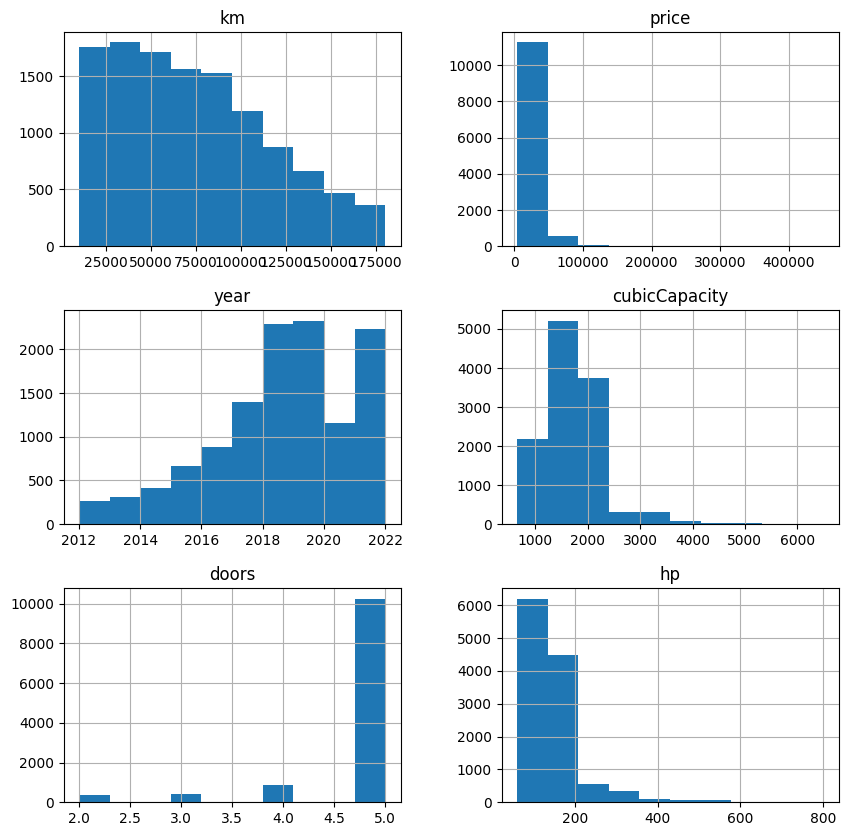

In [ ]:
df[campos_numericos].hist(ax = plt.figure(figsize = (10, 10)).gca())

#### Diagrama de cajas

Visualizamos los diagramas para todas las propiedades numéricas

In [ ]:
def draw_hist_boxplot(df, feature_name):
  # se dibuja el diagrama de cajas
  sns.boxplot(x = feature_name, data = df)
  # se dibujan sobre el diagrama todos los puntos de datos que tiene la propiedad
  sns.stripplot(x = feature_name, data = df, color = "#474646")

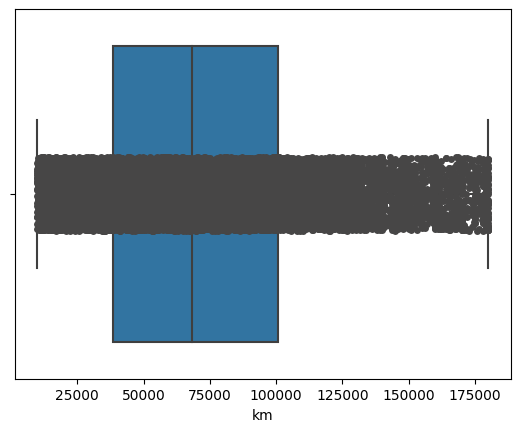

In [ ]:
draw_hist_boxplot(df, 'km')

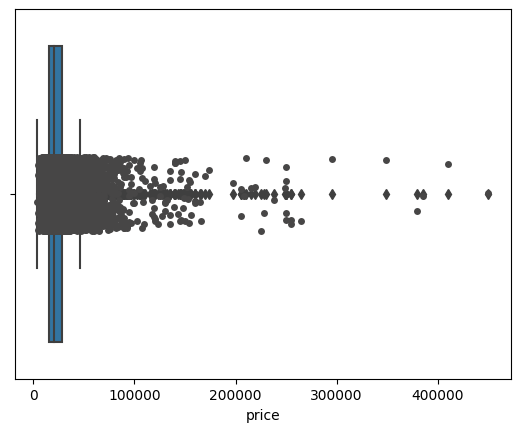

In [ ]:
draw_hist_boxplot(df, 'price')

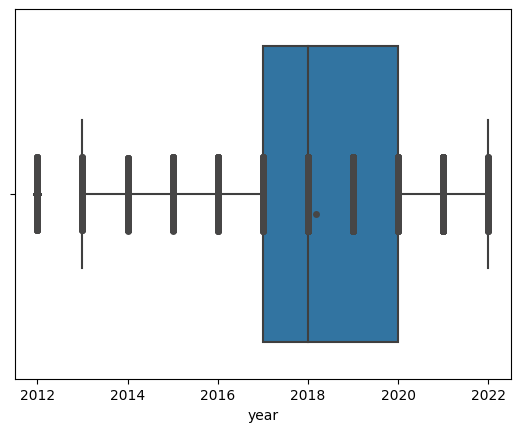

In [ ]:
draw_hist_boxplot(df, 'year')

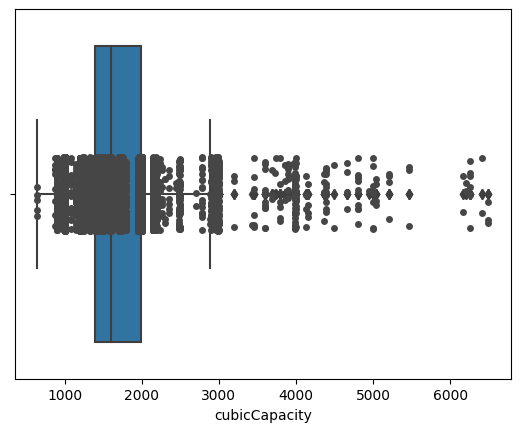

In [ ]:
draw_hist_boxplot(df, 'cubicCapacity')

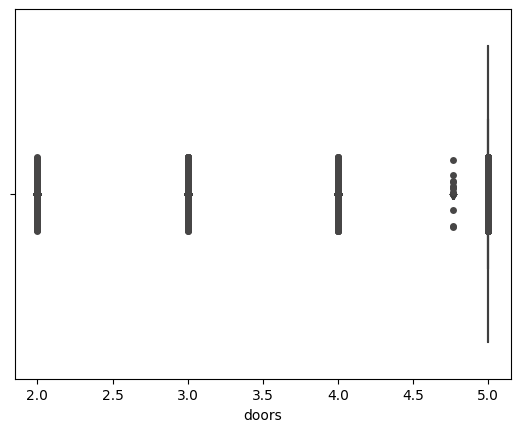

In [ ]:
draw_hist_boxplot(df, 'doors')

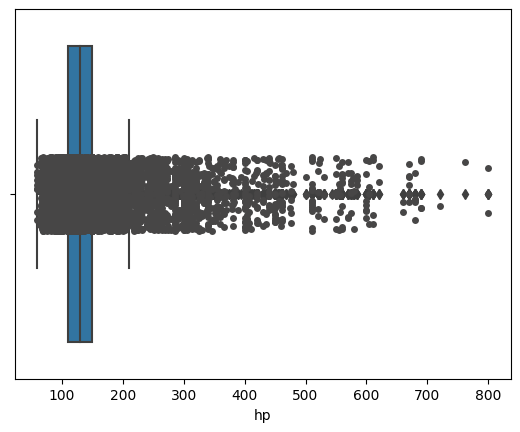

In [ ]:
draw_hist_boxplot(df, 'hp')

#### Eliminación de outliers

In [ ]:
def replace_outliers_with_median(df, feature_name):
    Q1 = df[feature_name].quantile(0.25)
    median = df[feature_name].quantile(0.5)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    df[feature_name] = np.where((df[feature_name] < lower_whisker) | 
                                (df[feature_name] > upper_whisker), 
                                 median, 
                                 df[feature_name])

In [ ]:
#for campo in campos_numericos:
#    replace_outliers_with_median(df, campo)

#### Escalamiento

Se transforman los valores de cada columna de tal manera que la media sea 0 y la desviación típica 1

In [ ]:
#sc = MinMaxScaler()
#df[campos_numericos] = sc.fit_transform(df[campos_numericos])

### Importacia de las propiedades y elección de variables relevantes para el estudio

<ipython-input-31-51570050dcc7>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), square=True, annot=True)


<Axes: >

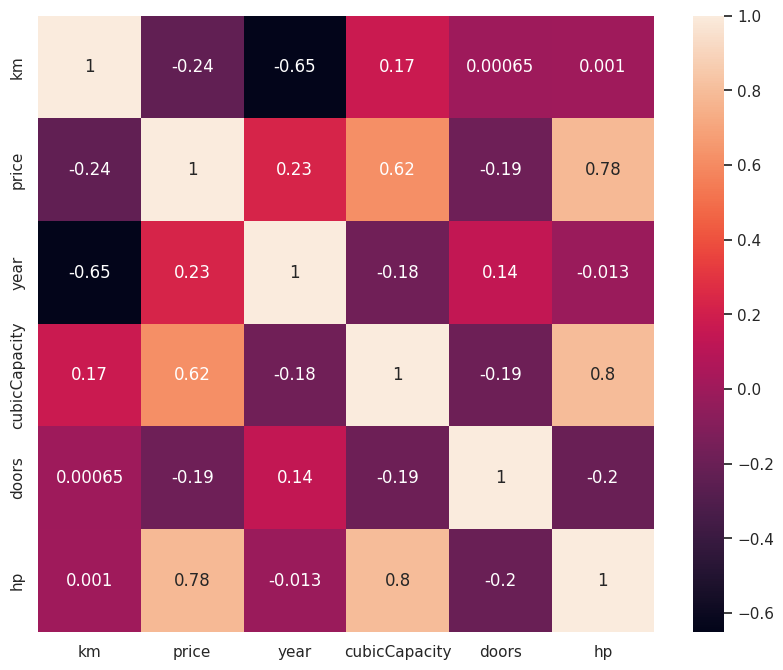

In [ ]:
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), square=True, annot=True)

In [ ]:
df = df.drop('title', axis=1)

## 4. División del conjunto de datos

In [ ]:
# separamos los datos entre datos de entrada y salida
X = df.drop(target, axis=1)
y = df[target]

# separamos los datos entre entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=1)

##5. Codificación de las variables categóricas

Todas las propiedades categóricas se han de convertir a forma numérica de tal forma que puedan ser utilizadas por el algoritmo de aprendizaje.

In [ ]:
#df = pd.get_dummies(df)

In [ ]:
dv = DictVectorizer(sparse=False)
dv.fit(df.to_dict(orient='records'))
X_train = dv.transform(X_train.to_dict(orient='records'))
X_test = dv.transform(X_test.to_dict(orient='records'))

## 6. Entrenamiento y predicción

### Elegir, instanciar y entrenar el modelo

In [ ]:
num_variables = X_train.shape[1]
print(num_variables)

542


In [ ]:
# instanciamos al modelo
model = Sequential()
model.add(Dense(num_variables, input_dim=num_variables, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_variables*2, activation='relu', kernel_initializer='he_uniform')) 
model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

# compilamos el modelo
model.compile(loss='mean_squared_error', 
              optimizer='adam')

In [ ]:
# Definir early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=40, mode='min')

# Definir reducción del learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=0.001, mode='min', verbose=0)


# definir el tamaño del lote
batch_size = int(math.sqrt(len(X_train)))

# entrenamiento
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop, reduce_lr], 
                    epochs=1000, 
                    batch_size=batch_size, 
                    use_multiprocessing=True)

Epoch 1/1000
96/96 [==============================] - 12s 107ms/step - loss: 441956768.0000 - val_loss: 163567664.0000 - lr: 0.0010
Epoch 2/1000
96/96 [==============================] - 11s 113ms/step - loss: 209303104.0000 - val_loss: 220576992.0000 - lr: 0.0010
Epoch 3/1000
96/96 [==============================] - 10s 102ms/step - loss: 181294256.0000 - val_loss: 133361064.0000 - lr: 0.0010
Epoch 4/1000
96/96 [==============================] - 9s 97ms/step - loss: 156795056.0000 - val_loss: 135106624.0000 - lr: 0.0010
Epoch 5/1000
96/96 [==============================] - 8s 79ms/step - loss: 144229104.0000 - val_loss: 152823568.0000 - lr: 0.0010
Epoch 6/1000
96/96 [==============================] - 10s 108ms/step - loss: 137170880.0000 - val_loss: 161702912.0000 - lr: 0.0010
Epoch 7/1000
96/96 [==============================] - 9s 89ms/step - loss: 137307488.0000 - val_loss: 215752144.0000 - lr: 0.0010
Epoch 8/1000
96/96 [==============================] - 8s 84ms/step - loss: 1332491

### Evaluar el rendimiento del modelo en los datos de prueba

In [ ]:
mse = model.evaluate(X_test, y_test)
print(f"Error cuadratico medio con los datos de prueba (MSE): {mse:.4f}")

94/94 [==============================] - 2s 15ms/step - loss: 86728496.0000
Error cuadratico medio con los datos de prueba (MSE): 86728496.0000


### Pérdida del modelo durante el entrenamiento

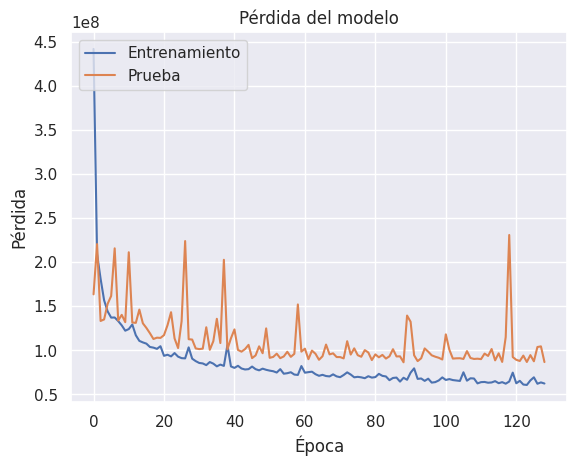

In [ ]:
# Graficar la pérdida del modelo durante el entrenamiento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

### Predicción con los datos de prueba

In [ ]:
y_pred = model.predict(X_test)

94/94 [==============================] - 1s 4ms/step


## 7. Evaluación

Error cuadrático medio

In [ ]:
mean_squared_error(y_test, y_pred)

86728508.29837911

Error absoluto medio

In [ ]:
mean_absolute_error(y_test, y_pred)

4144.859566971025

Representación gráfica de los valores predichos con los reales

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


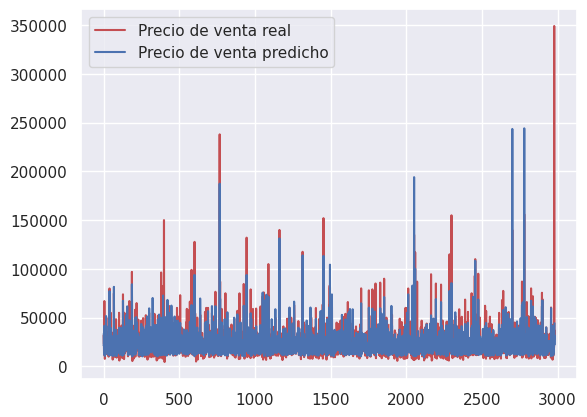

In [ ]:
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Precio de venta real')
plt.plot(xx, y_pred, c='b', label='Precio de venta predicho')
plt.axis('tight')
plt.legend()
plt.show()

## 8. Descargar el modelo

In [ ]:
with open('modelo_coches_net.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
with open('dict_vectorizer_coches_net.pck', 'wb') as f:
  pickle.dump((dv), f)